## Run Regressions on Generated Factors

## Load Processed Data

In [1]:
import pandas as pd 
from utils import *
import os

# load data
DATA_DIR = os.path.abspath("../../data/processed")

sage_factors = pd.read_csv(os.path.join(DATA_DIR, "sage_factors.csv"))
uniqueness = pd.read_csv(os.path.join(DATA_DIR, "uniqueness.csv"))
mod_ind_momentum = pd.read_csv(os.path.join(DATA_DIR, "mod_ind_momentum.csv"))

## Merge Data

In [2]:
# standardize date columns
sage_factors["MONTH_END"] = pd.to_datetime(sage_factors["MONTH_END"]) + pd.offsets.MonthEnd(0)
uniqueness["MONTH_END"] = pd.to_datetime(uniqueness["MONTH_END"]) + pd.offsets.MonthEnd(0)
mod_ind_momentum["MONTH_END"] = pd.to_datetime(mod_ind_momentum["MONTH_END"]) + pd.offsets.MonthEnd(0)

# merge data
data = pd.merge(sage_factors, uniqueness, on=["COMPANY_ID", "MONTH_END"], how="left").reset_index(drop=True)
data = pd.merge(data, mod_ind_momentum, on=["COMPANY_ID", "MONTH_END"], how="left").reset_index(drop=True)

# get column names for each momentum window combination 
window_sizes = [3, 6, 12, 24, 48]
momentum_columns = [f'avg_modality_momentum_{window}m' for window in window_sizes] + [f'avg_indication_momentum_{window}m' for window in window_sizes]

data = data.dropna(subset=["uniqueness"] + momentum_columns)
data.columns = [col.lower() for col in data.columns]

In [4]:
print(data.shape)
print(data.head(10).to_markdown(index=False))
assert(data.shape == (104506, 28))

(104506, 28)
| month_end           |   company_id |   excess_return_usd_ln |   excess_return_usd |   quality |     value |   coverage |    momentum |      size |   earnings_volatility |      growth |   trading_activity |   leverage |   volatility |   short_interest |   short_interest_pct_float | reg_group   |   uniqueness |   avg_modality_momentum_3m |   avg_modality_momentum_6m |   avg_modality_momentum_12m |   avg_modality_momentum_24m |   avg_modality_momentum_48m |   avg_indication_momentum_3m |   avg_indication_momentum_6m |   avg_indication_momentum_12m |   avg_indication_momentum_24m |   avg_indication_momentum_48m |
|:--------------------|-------------:|-----------------------:|--------------------:|----------:|----------:|-----------:|------------:|----------:|----------------------:|------------:|-------------------:|-----------:|-------------:|-----------------:|---------------------------:|:------------|-------------:|---------------------------:|---------------------------

## Restrict Historical Date Range

In [5]:
data = data[data["month_end"] >= "2000-01-01"]

## Define Factors

In [6]:
# sage factors
financial_factors = ['quality', 'value', 'coverage', 'momentum', 'size',
    'earnings_volatility', 'growth', 'trading_activity', 'leverage',
    'volatility','short_interest'# 'short_interest_pct_float'
]

uniqueness_factor = ['uniqueness']

# modality and indication momentum factors
window_sizes = [12]
mod_ind_momentum_factors = [f'avg_modality_momentum_{window}m' for window in window_sizes] + [f'avg_indication_momentum_{window}m' for window in window_sizes]
print(mod_ind_momentum_factors)

# Load the modalities and indications from the resources folder.
RESOURCES_DIR = os.path.abspath("../../resources")
with open(os.path.join(RESOURCES_DIR, "modaliities.txt"), "r") as f:
    modalities = [line.strip().upper() for line in f]
with open(os.path.join(RESOURCES_DIR, "indications.txt"), "r") as f:
    indications = [line.strip().upper() for line in f]

# raw modalities and indications
mod_ind_factors = [mi.lower() for mi in modalities + indications]

['avg_modality_momentum_12m', 'avg_indication_momentum_12m']


## Drop Rows with Inf or NaN

In [7]:
# # drop rows with inf or nan in 'short_interest_pct_float'
data = data.dropna(subset=['short_interest_pct_float'])

## Z-score Data

In [8]:
#id variable are used to connect results back to other data
id_variables = ['month_end', 'company_id']

dependent_variable = 'excess_return_usd_ln'
independent_variables = financial_factors + uniqueness_factor + mod_ind_momentum_factors

#the monthly regression function will create dummy variables from a column but you must specify which dummy value to drop
dummy_variables = []
dummy_drop_dict = {
}

#re z-score the data and set NAs to 0
z_scored_data = z_score_by_date(data, independent_variables, 'month_end', suffix = '', clip=3, fillna_zero = True)

## Run Regression

In [9]:
regression_stats, coefficients, coefficients_pivot, regression_fitted = run_monthly_regression(
    z_scored_data, 
    id_variables, 
    dependent_variable, 
    independent_variables, 
    dummy_variables, 
    dummy_drop_dict
)

## Show Sumamry Regression Stats and Historical R2

| statistic   |   r_squared |     y_mean |   y_stdev |      rmse |     y_mad |       mae |   std_improvement |   mad_improvement |
|:------------|------------:|-----------:|----------:|----------:|----------:|----------:|------------------:|------------------:|
| mean        |   0.104299  | -0.0148263 | 0.207436  | 0.203888  | 0.138376  | 0.134178  |        0.00354796 |       0.00419825  |
| median      |   0.0960807 | -0.0106123 | 0.202232  | 0.198776  | 0.133819  | 0.130342  |        0.00345624 |       0.00347705  |
| stdev       |   0.0474484 |  0.0893411 | 0.0464795 | 0.0454121 | 0.0281483 | 0.0274286 |        0.0010674  |       0.000719679 |


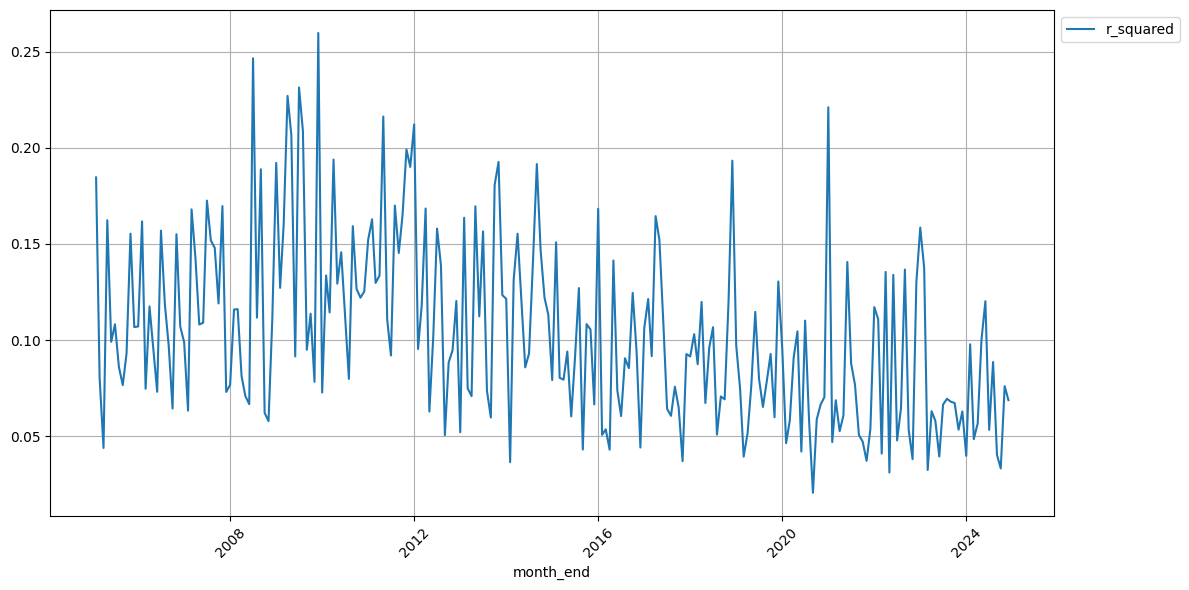

In [10]:
#calc summary stats gives us 
print(calc_summary_regression_stats(regression_stats).head().to_markdown(index=False))
#regression_stats = regression_stats.sort_values(by='month_end')
time_series_df_plot(regression_stats, 'month_end', ['r_squared'])

## Show Summary for Coefficients

In [11]:
summary = calc_summary_coefficients(coefficients, sort_order = independent_variables)
# summary["variable"] = summary["variable"].str[:20]
print(summary.to_markdown(index=False))

| variable                    |    avg_ceoff |     stdev |    Sharpe |   avg_p_value |   perc_below_0.05 |
|:----------------------------|-------------:|----------:|----------:|--------------:|------------------:|
| const                       | -0.0147536   | 0.0892143 | 0.165373  |     0.0838388 |         0.790795  |
| quality                     |  0.0052433   | 0.0206381 | 0.254059  |     0.456882  |         0.108787  |
| value                       |  0.00829268  | 0.0275193 | 0.30134   |     0.391645  |         0.142259  |
| coverage                    |  0.0050561   | 0.0197364 | 0.256182  |     0.476337  |         0.0334728 |
| momentum                    |  0.00135912  | 0.0222701 | 0.0610286 |     0.452906  |         0.0962343 |
| size                        |  0.00259888  | 0.0303557 | 0.0856143 |     0.390952  |         0.133891  |
| earnings_volatility         | -0.00172609  | 0.0172495 | 0.100066  |     0.486613  |         0.0627615 |
| growth                      | -0.00

## Graph Cumulative Coefficients

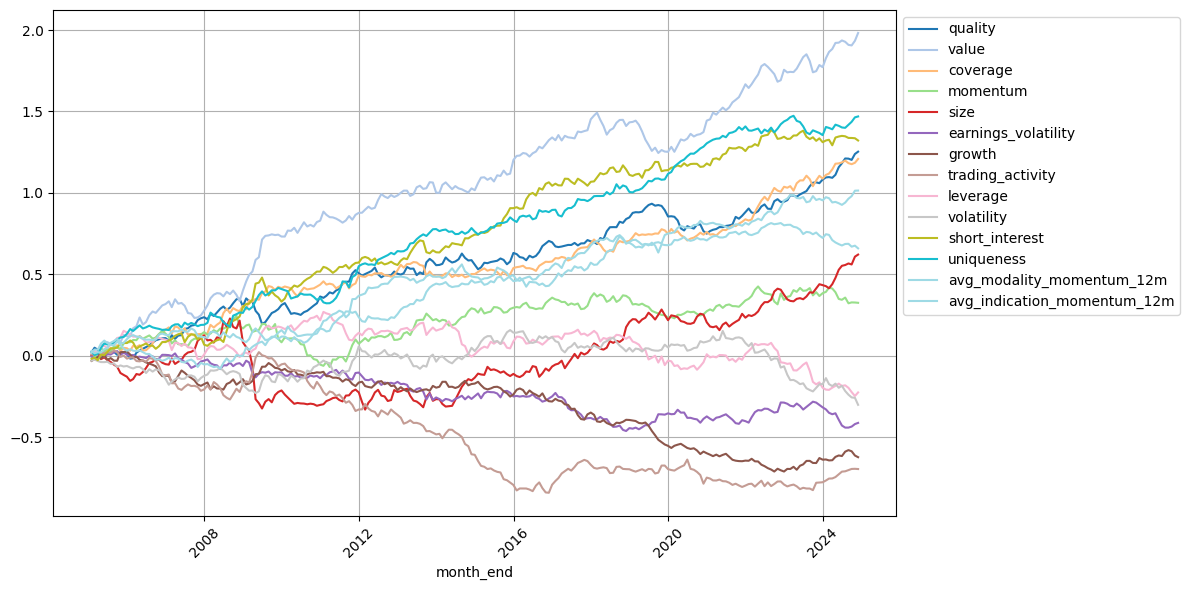

In [12]:
cumulative_ceoff = calculate_cumulative_coefficients(coefficients_pivot, 'month_end')
time_series_df_plot(cumulative_ceoff, 'month_end', financial_factors + ["uniqueness"] + [mod_ind_momentum_factors])